In [1]:
from tqdm import tqdm
import optuna
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_log_error

In [2]:
data = pd.read_csv('./data/train.csv')
data

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0
...,...,...,...,...,...,...,...,...,...
749995,749995,male,28,193.0,97.0,30.0,114.0,40.9,230.0
749996,749996,female,64,165.0,63.0,18.0,92.0,40.5,96.0
749997,749997,male,60,162.0,67.0,29.0,113.0,40.9,221.0
749998,749998,male,45,182.0,91.0,17.0,102.0,40.3,109.0


In [3]:
data.isna().sum()

id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

In [4]:
data['Sex'] = data['Sex'].apply(lambda x: 1 if x == 'male' else 0)
data

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,1,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,0,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,0,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,1,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,0,38,166.0,61.0,25.0,102.0,40.6,146.0
...,...,...,...,...,...,...,...,...,...
749995,749995,1,28,193.0,97.0,30.0,114.0,40.9,230.0
749996,749996,0,64,165.0,63.0,18.0,92.0,40.5,96.0
749997,749997,1,60,162.0,67.0,29.0,113.0,40.9,221.0
749998,749998,1,45,182.0,91.0,17.0,102.0,40.3,109.0


In [5]:
data.drop(columns=['id'], inplace=True)

In [6]:
data.describe()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,0.499039,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781
std,0.499999,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349
min,0.000000,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,0.000000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,0.000000,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,1.000000,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,1.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


<Axes: >

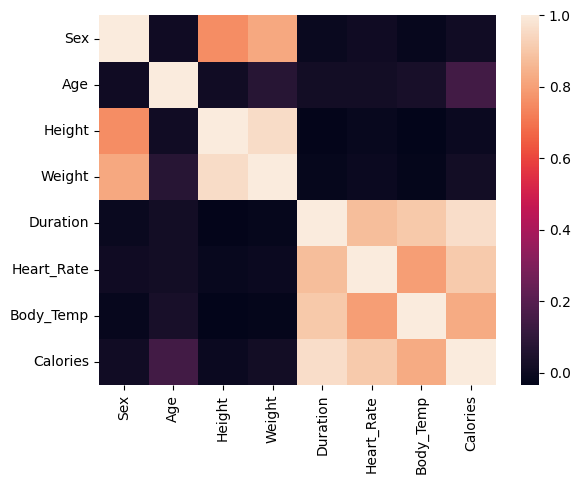

In [7]:
sns.heatmap(data.corr())

Text(0.5, 1.0, 'Heart Rate x Duration')

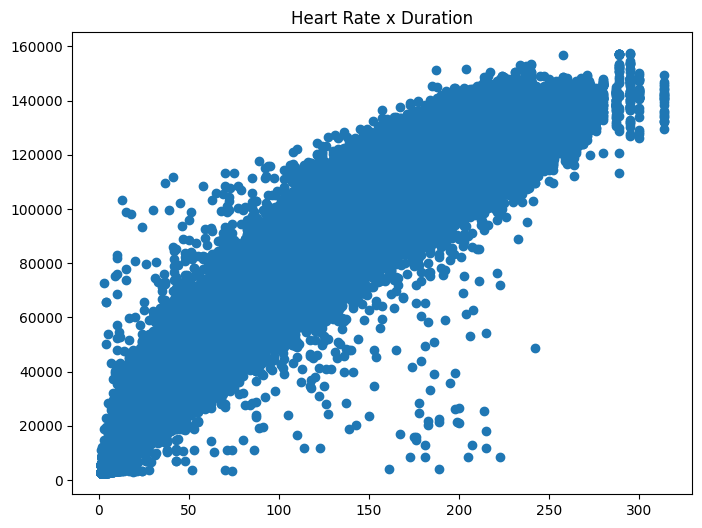

In [8]:
figure = plt.figure(figsize=(8, 6))

plt.scatter(data['Calories'], data['Heart_Rate'] * data['Duration'] * data['Body_Temp'])
plt.title('Heart Rate x Duration')

In [9]:
data['SMM'] = 0.244 * data['Weight'] + 7.8 * data['Height'] + 6.6 * data['Sex'] - 0.098 * data['Age'] + 0.4
data['BMI'] = data['Weight'] / (data['Height']/100)**2

#SMM - Skeletal Muscle Mass
#BMI - Body Mass Index

data.head(5)

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,SMM,BMI
0,1,36,189.0,82.0,26.0,101.0,41.0,150.0,1497.680,22.955684
1,0,64,163.0,60.0,8.0,85.0,39.7,34.0,1280.168,22.582709
2,0,51,161.0,64.0,7.0,84.0,39.8,29.0,1266.818,24.690405
3,1,20,192.0,90.0,25.0,105.0,40.7,140.0,1524.600,24.414062
4,0,38,166.0,61.0,25.0,102.0,40.6,146.0,1306.360,22.136740


Text(0.5, 1.0, 'Duration x Heart rate x BMI x Body Temp')

<Figure size 800x1000 with 0 Axes>

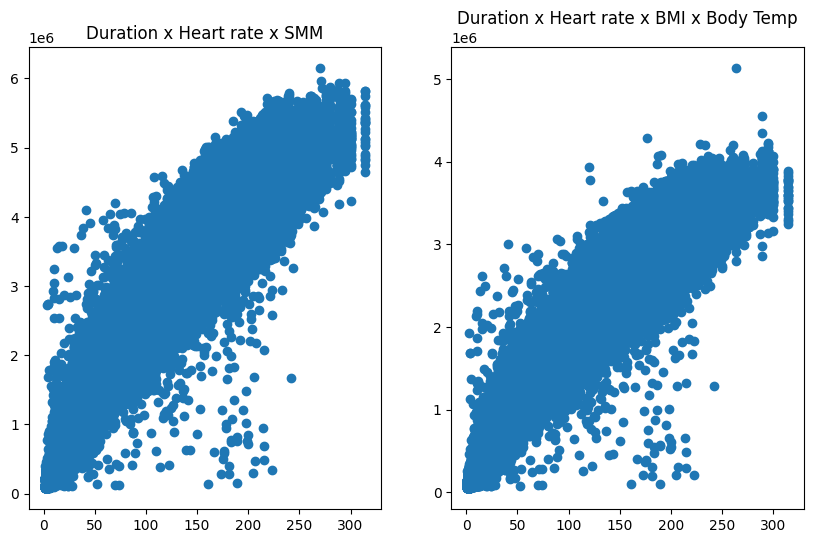

In [10]:
figure = plt.figure(figsize=(8, 10))

fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(10, 6))

ax3.scatter(data['Calories'], data['Duration'] * data['SMM'] * data['Heart_Rate'])
ax3.set_title('Duration x Heart rate x SMM')

ax4.scatter(data['Calories'], data['Duration'] * data['BMI'] * data['Heart_Rate'] * data['Body_Temp'])
ax4.set_title('Duration x Heart rate x BMI x Body Temp')

In [11]:
data['SMM_DUR_HEART'] = data['Duration'] * data['SMM'] * data['Heart_Rate']
data['Cardio'] = data['Heart_Rate'] * data['Duration'] * data['Body_Temp']

data.head(5)

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,SMM,BMI,SMM_DUR_HEART,Cardio
0,1,36,189.0,82.0,26.0,101.0,41.0,150.0,1497.680,22.955684,3932907.680,107666.0
1,0,64,163.0,60.0,8.0,85.0,39.7,34.0,1280.168,22.582709,870514.240,26996.0
2,0,51,161.0,64.0,7.0,84.0,39.8,29.0,1266.818,24.690405,744888.984,23402.4
3,1,20,192.0,90.0,25.0,105.0,40.7,140.0,1524.600,24.414062,4002075.000,106837.5
4,0,38,166.0,61.0,25.0,102.0,40.6,146.0,1306.360,22.136740,3331218.000,103530.0


In [12]:
X = data.drop(columns=['Calories'])
y = data['Calories']

In [ ]:
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()

scaler = StandardScaler()
scaler.fit(X[numeric_cols])
X[numeric_cols] = scaler.transform(X[numeric_cols])

In [15]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10)
    }
    model = XGBRegressor(**params, random_state=42, n_jobs=-1, tree_method='hist')

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in kf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_pred = np.clip(y_pred, 0, None) 

        rmsle = root_mean_squared_log_error(y_val, y_pred)
        scores.append(rmsle)

    return np.mean(scores)


In [16]:
n_trials = 50
pbar = tqdm(total=n_trials, desc="Optuna search")

def callback(study, trial):
    pbar.update(1)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, callbacks=[callback])
print(f'Best hyperparameters: {study.best_params}')

pbar.close()

Optuna search:   0%|          | 0/50 [00:00<?, ?it/s][I 2025-06-13 16:05:17,542] A new study created in memory with name: no-name-bd515c90-0c7d-4a6c-9c5f-c232786b0f72
[I 2025-06-13 16:05:28,633] Trial 0 finished with value: 0.06369264127152834 and parameters: {'n_estimators': 295, 'max_depth': 6, 'learning_rate': 0.14318704611062438, 'subsample': 0.8070403907984343, 'colsample_bytree': 0.9661954359194744, 'gamma': 2.6785483764122593, 'min_child_weight': 8}. Best is trial 0 with value: 0.06369264127152834.
Optuna search: 100%|██████████| 50/50 [34:34<00:00, 41.49s/it]

Best hyperparameters: {'n_estimators': 581, 'max_depth': 10, 'learning_rate': 0.027729440803207755, 'subsample': 0.773055853128417, 'colsample_bytree': 0.866644971570646, 'gamma': 3.284841367092004, 'min_child_weight': 3}


In [24]:
X_test = pd.read_csv('./data/test.csv')
X_test['Sex'] = X_test['Sex'].apply(lambda x: 1 if x == 'male' else 0)
X_test.drop(columns=['id'], inplace=True)


X_test['SMM'] = 0.244 * X_test['Weight'] + 7.8 * X_test['Height'] + 6.6 * X_test['Sex'] - 0.098 * X_test['Age'] + 0.4
X_test['BMI'] = X_test['Weight'] / (X_test['Height']/100)**2
X_test['SMM_DUR_HEART'] = X_test['Duration'] * X_test['SMM'] * X_test['Heart_Rate']
X_test['Cardio'] = X_test['Heart_Rate'] * X_test['Duration'] * X_test['Body_Temp']

numeric_cols=X_test.select_dtypes(include=np.number).columns.tolist()

scaler = StandardScaler()
scaler.fit(X_test[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


In [ ]:
params = {'n_estimators': 581, 'max_depth': 10, 'learning_rate': 0.027729440803207755, 'subsample': 0.773055853128417, 'colsample_bytree': 0.866644971570646, 'gamma': 3.284841367092004, 'min_child_weight': 3}

model=XGBRegressor(**params,random_state=42,n_jobs=-1,tree_method="hist")

model.fit(X, y)

y_pred = model.predict(X_test)
y_pred = np.clip(y_pred, 0, None)

Cross Validation RMSLE: 0.0


In [35]:
submission_df = pd.read_csv('./data/sample_submission.csv')
submission_df['Calories'] = y_pred
submission_df.to_csv('submission.csv', index=False)